<a href="https://colab.research.google.com/github/Debajyoti2004/coursera-test/blob/main/Create_Word_vector(embedding_vector_from_scratch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving shakespeare.txt to shakespeare.txt


In [2]:
import nltk
import re
from collections import Counter
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
class preprocess_text:
  def __init__(self,text_file,stopword,stoprwords_file=None):
    self.text_file = text_file
    self.stoprwords_file = stoprwords_file
    self.stopwords=stopword

  def load_data(self):
    with open(self.text_file, 'r') as file:
      text = file.read()

    if self.stopwords==True:
      with open(self.stoprwords_file, 'r') as file:
        stopwords = file.read().splitlines()
      return text,stopwords
    else:
      return text

  def preprocessing(self):
    data=self.load_data()
    data=re.sub(r'[,;!?-]','.',data)
    data=word_tokenize(data)
    data=[ch.lower() for ch in data if ch.isalpha() or ch=='.']
    return data


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
preprocess_txt=preprocess_text(text_file='/content/shakespeare.txt',stopword=False)
txt_data=preprocess_txt.preprocessing()

In [6]:
print("Number of token:",len(txt_data))
print("first 15 token:",txt_data[:15])

Number of token: 60976
first 15 token: ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [7]:
fdist=nltk.FreqDist(txt_data)
print("Number of unique words:",len(fdist))
print("Most 20 common words:",fdist.most_common(20))

Number of unique words: 5775
Most 20 common words: [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


In [23]:
import torch
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import numpy as np

class Word2VecDataset(Dataset):
    def __init__(self, data, vocab_size, context_size):
        self.data = data
        self.vocab_size = vocab_size
        self.context_size = context_size
        self.word2idx, self.idx2word = self.build_vocab(data)
        self.context_target_pairs = self.generate_context_target_pairs()

    def build_vocab(self, data):
        words = sorted(set(data))
        word2idx = {word: idx for idx, word in enumerate(words)}
        idx2word = {idx: word for word, idx in word2idx.items()}
        return word2idx, idx2word

    def generate_context_target_pairs(self):
        pairs = []
        for i in range(self.context_size, len(self.data) - self.context_size):
            target_word = self.data[i]
            context_words = (
                self.data[i - self.context_size:i] + self.data[i + 1:i + self.context_size + 1]
            )
            context_vector = np.zeros(self.vocab_size)
            for word in context_words:
                context_vector[self.word2idx[word]] += 1
            context_vector /= len(context_words)

            target_vector = np.zeros(self.vocab_size)
            target_vector[self.word2idx[target_word]] = 1
            pairs.append((torch.tensor(context_vector, dtype=torch.float32),
                          torch.tensor(target_vector, dtype=torch.float32)))
        return pairs

    def __len__(self):
        return len(self.context_target_pairs)

    def __getitem__(self, idx):
        return self.context_target_pairs[idx]


In [24]:
data=txt_data
vocab_size=len(fdist)
context_size=2
dataset=Word2VecDataset(data,vocab_size,context_size)
print("Number of pairs:",len(dataset))
print("shape:",dataset[0][0].shape,dataset[0][1].shape)

Number of pairs: 60972
shape: torch.Size([5775]) torch.Size([5775])


In [25]:
dataloader=DataLoader(dataset,batch_size=400,shuffle=True)
for x,y in dataloader:
  print(x.shape,y.shape)
  break

torch.Size([400, 5775]) torch.Size([400, 5775])


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim

class Word2VecModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecModel, self).__init__()
        self.embedding_layer = nn.Linear(vocab_size, embedding_dim, bias=True)
        self.output_layer = nn.Linear(embedding_dim, vocab_size, bias=True)
        self.softmax = nn.Softmax(dim=1)
        nn.init.uniform_(self.embedding_layer.weight, -0.5, 0.5)
        nn.init.uniform_(self.output_layer.weight, -0.5, 0.5)

    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.output_layer(x)
        return self.softmax(x)

    def get_embeddings(self):
        W1 = self.embedding_layer.weight.data.T
        W2 = self.output_layer.weight.data
        embeddings = (W1 + W2) / 2
        return embeddings

In [51]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [52]:
def train(model, data_loader, num_epochs, learning_rate, decay_epochs=10, decay_factor=0.9):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_epochs, gamma=decay_factor)
    model = model.to(device)
    losses=[]

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in data_loader:
            optimizer.zero_grad()
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()

        scheduler.step()
        losses.append(epoch_loss / len(data_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(data_loader)}")

    return losses,model


In [53]:
word2vec=Word2VecModel(vocab_size=len(fdist),embedding_dim=50)

In [54]:
losses,trained_model=train(word2vec,dataloader,num_epochs=50,learning_rate=0.01)

Epoch 1/50, Loss: 8.528119679369958
Epoch 2/50, Loss: 8.503625103071624
Epoch 3/50, Loss: 8.503618776408675
Epoch 4/50, Loss: 8.50337136960497
Epoch 5/50, Loss: 8.50321931153341
Epoch 6/50, Loss: 8.503140985576156
Epoch 7/50, Loss: 8.503123227287741
Epoch 8/50, Loss: 8.500524745267981
Epoch 9/50, Loss: 8.497450267567354
Epoch 10/50, Loss: 8.495464225220525
Epoch 11/50, Loss: 8.494152455548056
Epoch 12/50, Loss: 8.492220124388053
Epoch 13/50, Loss: 8.486488211388682
Epoch 14/50, Loss: 8.482168415792627
Epoch 15/50, Loss: 8.47956016640258
Epoch 16/50, Loss: 8.478525485867769
Epoch 17/50, Loss: 8.476251309214074
Epoch 18/50, Loss: 8.46963614420174
Epoch 19/50, Loss: 8.464703541175991
Epoch 20/50, Loss: 8.46114818722594
Epoch 21/50, Loss: 8.458055764241935
Epoch 22/50, Loss: 8.45440640792348
Epoch 23/50, Loss: 8.44969453375324
Epoch 24/50, Loss: 8.445559189989677
Epoch 25/50, Loss: 8.442738370957718
Epoch 26/50, Loss: 8.439255745582331
Epoch 27/50, Loss: 8.435200286067388
Epoch 28/50, Loss

In [55]:
for param in trained_model.parameters():
  print(param.shape)

torch.Size([50, 5775])
torch.Size([50])
torch.Size([5775, 50])
torch.Size([5775])


In [56]:
embedding_vector=trained_model.get_embeddings()
print(embedding_vector.shape)

torch.Size([5775, 50])


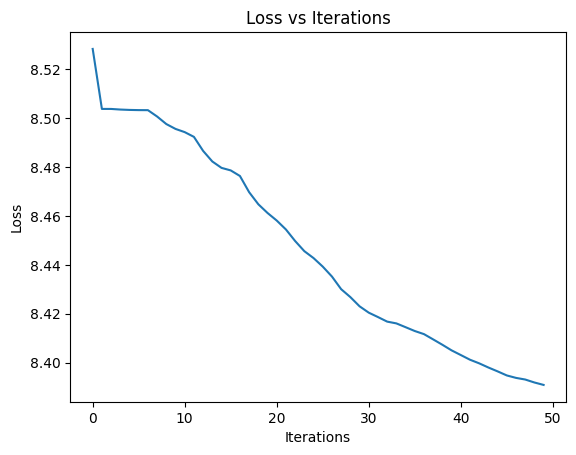

In [57]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.show()


In [61]:
words = ['king', 'queen','lord','man', 'woman','dog','horse',
         'rich','happy','sad']

embs = np.array(embedding_vector.cpu())
word2idx,idx2word=dataset.build_vocab(data)

idxs=[word2idx[word] for word in words]
X=embs[idxs,:]
print(X.shape,embs.shape)
print("Indexes:")
print(idxs)

(10, 50) (5775, 50)
Indexes:
[2744, 3949, 2960, 3022, 5672, 1452, 2471, 4189, 2315, 4276]


In [63]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(X)
X=pca.transform(X)
print("N=50 -> N=2:")
print(X.shape)

N=50 -> N=2:
(10, 2)


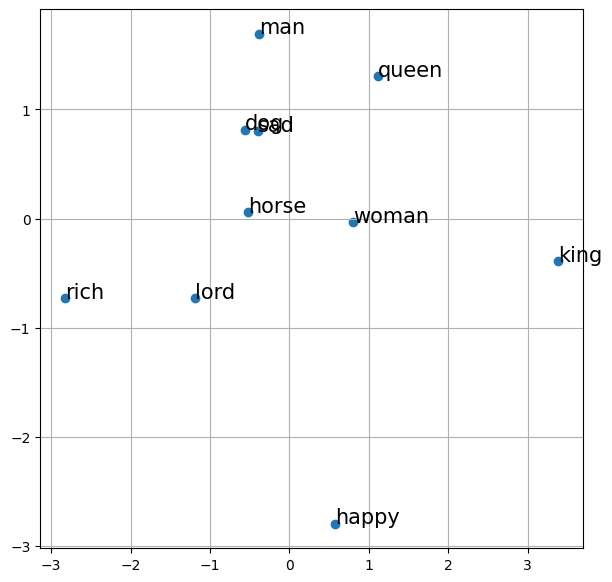

In [66]:
plt.figure(figsize=(7,7))
plt.scatter(X[:,0],X[:,1])

for i in range(len(words)):
    plt.annotate(words[i], (X[i,0], X[i,1]), fontsize=15)
plt.grid()

In [67]:
word='king'
idx=word2idx[word]
print("Embedding  Vector of word {} is {}".format(word,embs[idx]))

Embedding  Vector of word king is [-0.76992023 -0.28828883  0.4671859   0.33945966  0.997905   -0.92267734
 -0.1125244   0.02006489 -0.02011998 -0.6200999  -0.60960436  0.3321667
 -0.16124342 -0.26498544  0.7329503  -0.6150857   0.5203255  -0.5045514
  0.33355933  0.29231066  1.5489553   0.29336977  0.66821027 -0.21840519
 -0.33599138  0.94886124 -0.19700664  1.5497456  -0.7251493   0.55054
  0.45790178 -0.6553656  -0.3540169  -0.7531532  -0.4993543   1.0900422
 -0.18744054 -1.6474795  -0.24638727 -0.8798275   0.41355678  0.4484946
  0.7223591   0.29367924 -0.01614841  0.44223148 -0.33000734  0.35094017
 -0.95097566  0.57266104]
